In [ ]:
%pip install scipy --upgrade
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import numpy as np
import pandas as pd
import statsmodels.api as sm
%pip install pymoo
import pymoo as pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.5

# **Bidding Decisions (Multi-Agent)**

## **Myerson Distribution**
Below is a function that simulates random samples from the Myerson distribution in section 4.4 of Roger Myerson's 2005 book.
This is a generalized version of normal & lognormal distribution.


In [ ]:
# https://www.solver.com/risk-solver-help/psi-function-help/simulation/distributions/psimyerson
# https://en.wikipedia.org/wiki/Roger_Myerson

def randomMyerson(n,q1,q2,q3,lower=-1*math.inf,upper=math.inf,tl=0.5):
   #n: the number of random samples
   #q1: xx percentile, xx<50 & usually xx=25
   #q2: 50 percentile
   #q3: xx percentile, xx>50 & usually xx=75
   #lower: minimum possible value
   #upper: maximum possible value
   #tl: tail probability = P(X<q1)+P(X>q3)
   ######################################
   x=np.random.uniform(0,1,n)
   id=np.where(x>0.999999)
   x[id]=0.999999
   id=np.where(x<0.000001)
   x[id]=0.000001
   #Above avoids sampling values that are too extreme
   norml=stats.norm.ppf(x)/stats.norm.ppf(1-tl/2)
   br=(q3-q2)/(q2-q1)
   if br==1:
     res=q2+(q3-q2)*norml
   else:
     res=q2+(q3-q2)*(br**norml-1)/(br-1)
   #
   #Below is R code operations
   #pmin(pmax(res, lower), upper)
   #
   id=np.where(res<lower)
   res[id]=lower
   id=np.where(res>upper)
   res[id]=upper
   return res

In [ ]:
#cost parameters
costq1=86
costq2=100
costq3=120

#parameters of opponents' bids
oppbidq1=120
oppbidq2=140
oppbidq3=180


In [ ]:
#Number of simulation runs
S=10000

np.random.seed(9527)

##Pre-draw independent oppbids & costs
oppbids_ind=np.empty(S)
cost_ind=np.empty(S)

opponents_ind=np.random.choice(np.array([1,2,3,4,5]),S,replace=True,
                 p=np.array([0.2,0.3,0.3,0.1,0.1]))

print(opponents_ind[0:5])

cost_ind=randomMyerson(S,costq1,costq2,costq3,lower=0)

print(cost_ind[0:5])


[2 2 2 5 3]
[115.7423522  131.12997084  94.08198377 125.89174399  73.67353936]


In [ ]:
for s in range(0,S):
  oppbids=randomMyerson(opponents_ind[s],oppbidq1,oppbidq2,oppbidq3,lower=0)
  #print(oppbids)
  oppbids_ind[s]=np.min(oppbids)
  #print(np.min(oppbids))
  cost_ind[s]=cost_ind[s]


In [ ]:
#Try different bidding values
bval=np.arange(100,201,5)

win=np.empty([S,len(bval)])
profit=np.empty([S,len(bval)])
avgprofit=np.empty(len(bval))
sdprofit=np.empty(len(bval))
wins=np.empty(len(bval))

for i in range(0,len(bval)):
  win[:,i]=(bval[i]<oppbids_ind)
  wins[i]=np.sum(win[:,i])
  #
  profit[:,i]=win[:,i]*(bval[i]-cost_ind)
  avgprofit[i]=np.mean(profit[:,i])
  sdprofit[i]=np.std(profit[:,i])

In [ ]:
print(win[0:5,2])
print(bval[2]-cost_ind[0:5])
win[0:5,2]*(bval[2]-cost_ind[0:5])

[1. 1. 0. 1. 0.]
[ -5.7423522  -21.12997084  15.91801623 -15.89174399  36.32646064]


array([ -5.7423522 , -21.12997084,   0.        , -15.89174399,
         0.        ])

Text(0, 0.5, 'E[Profit]')

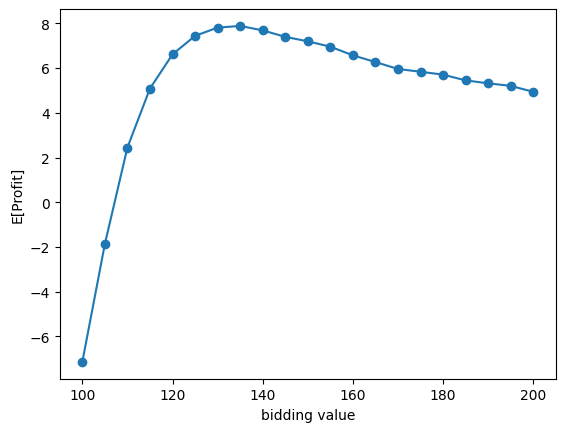

In [ ]:
plt.figure()
plt.plot(bval,avgprofit, marker='o')
plt.xlabel("bidding value")
plt.ylabel("E[Profit]")

In [ ]:
bval[np.argmax(avgprofit)]

135

# **The Winners' Curse**

In [ ]:
#Capture stochastic dependencies between C and A
#corrleation coefficient
corr_oppcost=0.4

#Below simulates bivariate standard normal variates
#both have standard deviation of 1
cov_oppcost=corr_oppcost*1*1
#variance-covariance matrix
Sigma_oppcost=np.array([1, cov_oppcost, cov_oppcost, 1]).reshape(2, 2)
Sigma_oppcost

array([[1. , 0.4],
       [0.4, 1. ]])

In [ ]:
S=10000
np.random.seed(9527)
binorm=np.random.multivariate_normal([0,0], Sigma_oppcost, S)

#check the correlation of simulated values
np.corrcoef(binorm[:,0], binorm[:,1])[0, 1]

0.4024848945618465

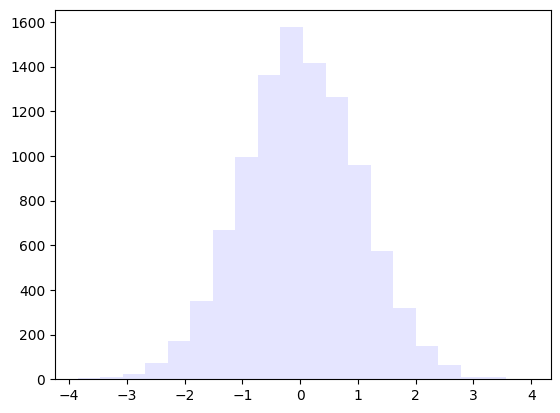

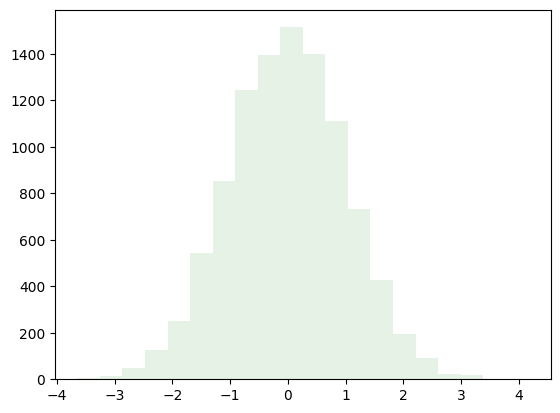

In [ ]:
plt.hist(binorm[:,0],bins=20,alpha=0.1,color='blue')
plt.show()

plt.hist(binorm[:,1],bins=20,alpha=0.1,color='green')
plt.show()

In [ ]:
binorm[0:5,1]

array([-0.56379424,  2.1269154 , -0.76731339,  0.34186664, -1.31057903])

In [ ]:
stats.norm.cdf(binorm[0:5,1],0,1)

array([0.28644709, 0.98328644, 0.2214476 , 0.63377437, 0.09500001])

In [ ]:
#Transform the simulated standard normal variates
#into uniform (0, 1) variates

birand=np.empty([S,2])
birand[:,0]=stats.norm.cdf(binorm[:,0],0,1)
birand[:,1]=stats.norm.cdf(binorm[:,1],0,1)

#check correlation between two uniform(0, 1) variates
np.corrcoef(birand[:,0], birand[:,1])[0, 1]

0.3881647088977288

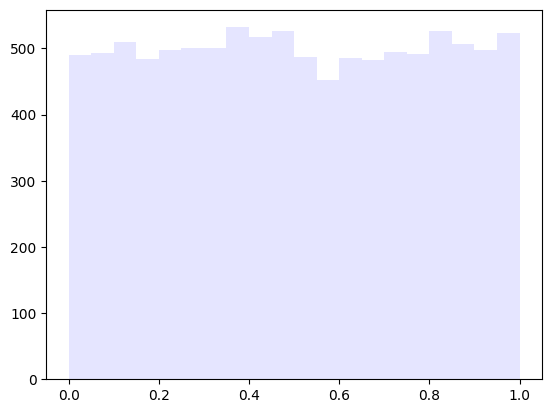

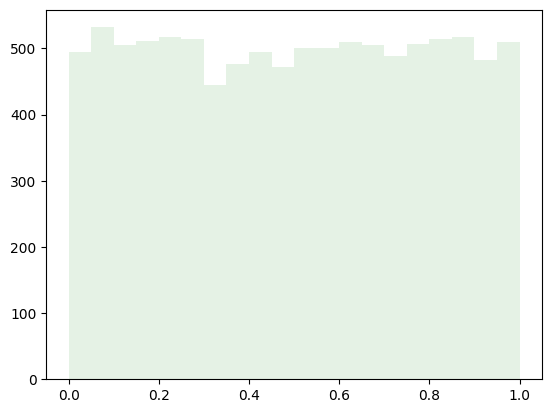

In [ ]:
plt.hist(birand[:,0],bins=20,alpha=0.1,color='blue')
plt.show()

plt.hist(birand[:,1],bins=20,alpha=0.1,color='green')
plt.show()

In [ ]:
print(stats.describe(oppbids_ind))
stats.describe(cost_ind)

DescribeResult(nobs=10000, minmax=(100.82374421299569, 913.7032854078661), mean=133.10246554306136, variance=2052.564785619102, skewness=5.790991191415649, kurtosis=56.28647881509349)


DescribeResult(nobs=10000, minmax=(59.81910140985481, 370.41910634220125), mean=107.13854055461469, variance=916.8787794138905, skewness=1.7300383250452893, kurtosis=4.9597318925061336)

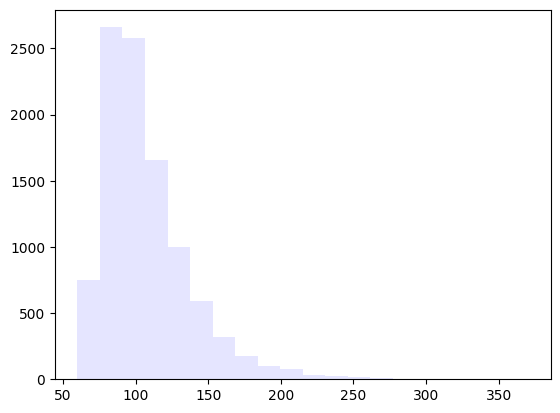

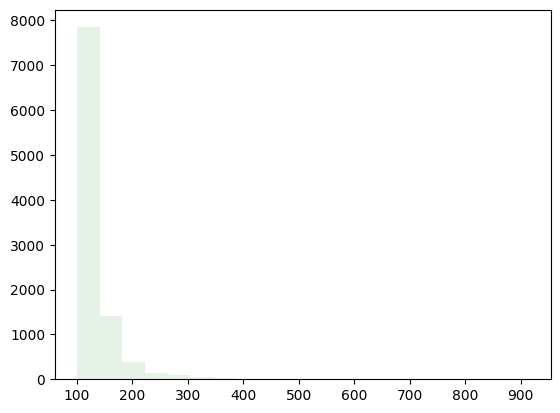

In [ ]:
plt.hist(cost_ind,bins=20,alpha=0.1,color='blue')
plt.show()

plt.hist(oppbids_ind,bins=20,alpha=0.1,color='green')
plt.show()

In [ ]:
##Pre-draw correlated oppbids & costs
cost_corr=np.round(np.quantile(cost_ind,birand[:,0]),0)
oppbids_corr=np.round(np.quantile(oppbids_ind,birand[:,1]),0)

#check correlation between simulated oppbids & costs
np.corrcoef(cost_corr, oppbids_corr)[0, 1]

0.3219363606141219

In [ ]:
win_corr=np.empty([S,len(bval)])
profit_corr=np.empty([S,len(bval)])
avgprofit_corr=np.empty(len(bval))
sdprofit_corr=np.empty(len(bval))
wins_corr=np.empty(len(bval))

for i in range(0,len(bval)):
  win_corr[:,i]=(bval[i]<oppbids_corr)
  wins_corr[i]=np.sum(win_corr[:,i])
  #
  profit_corr[:,i]=win_corr[:,i]*(bval[i]-cost_corr)
  avgprofit_corr[i]=np.mean(profit_corr[:,i])
  sdprofit_corr[i]=np.std(profit_corr[:,i])

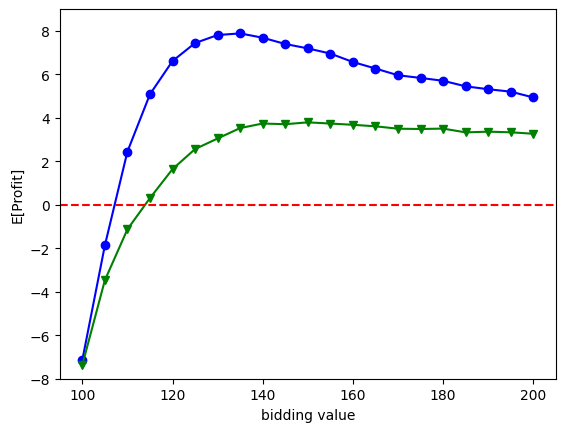

In [ ]:
plt.ylim([-8, 9])
plt.plot(bval,avgprofit, marker='o',color='blue')
plt.plot(bval,avgprofit_corr, marker='v',color='green')
plt.axhline(0, color = 'r',linestyle='dashed')
plt.xlabel("bidding value")
plt.ylabel("E[Profit]")
plt.show()

In [ ]:
bval[np.argmax(avgprofit_corr)]

150

# **The Optimal Stopping Problem**

# A Model for Strict Success

In [ ]:
def simulate_dating(population=100, phase1_fraction=1/np.exp(1), num_iterations=1):
    is_soulmate = np.zeros(num_iterations)
    phase1_size = round(population * phase1_fraction)
    np.random.seed(9527)
    for case_idx in range(num_iterations):
        # scores of potential mates
        score = np.random.normal(size = population)
        #
        #score = np.random.uniform(size = population)
        optimal_score = max(score)

        # we date the first phase1_size people
        # and note the maximum score in that group
        cutoff_score = max(score[:phase1_size])

        # now select as your life partner the next date with a better score
        # pick the last one if nobody better came along before then
        if len(np.where(score[phase1_size:population] > cutoff_score)[0]) == 0:
            spouse_index = population - 1
        else:
            spouse_index = phase1_size + np.where(score[phase1_size:population] > cutoff_score)[0][0]

        is_soulmate[case_idx] = (score[spouse_index] == optimal_score)

    return np.mean(is_soulmate)

In [ ]:
phase1_fractions = np.round(np.arange(0.05, 0.96, 0.01).tolist(), 2)
means = np.zeros(len(phase1_fractions))
for idx in range(len(phase1_fractions)):
    means[idx]=simulate_dating(population=100,
                phase1_fraction=phase1_fractions[idx],
                num_iterations = 10000)
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


The phase1_fractions has max mean:  0.39


Text(0, 0.5, 'means')

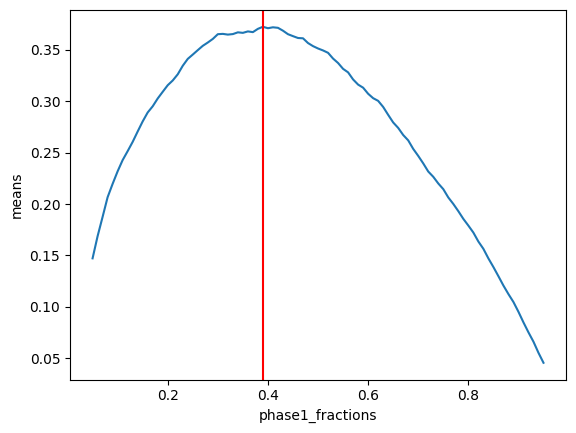

In [ ]:
max_means_frac = phase1_fractions[np.where(means == max(means))]
print("The phase1_fractions has max mean: ", max_means_frac[0])
plt.plot(phase1_fractions, means)
plt.axvline(max_means_frac, color = 'r')
plt.xlabel('phase1_fractions')
plt.ylabel('means')

# A Model for Average Score Maximization

In [ ]:
def simulate_dating_2(population = 100, phase1_fraction = 1 / np.exp(1), num_iterations = 1):
    spouse_scores = np.zeros(num_iterations)
    phase1_size = round(population * phase1_fraction)
    np.random.seed(9527)
    for case_idx in range(num_iterations):
        # scores of potential mates
        score = np.random.normal(size = population)
        #
        #score = np.random.uniform(size = population)
        optimal_score = max(score)

        # we date the first phase1_size people
        # and note the maximum score in that group
        cutoff_score = max(score[:phase1_size])

        # now select as your life partner the next date with a better score
        # pick the last one if nobody better came along before then
        if len(np.where(score[phase1_size:population] > cutoff_score)[0]) == 0:
            spouse_index = population - 1
        else:
            spouse_index = phase1_size + np.where(score[phase1_size:population] > cutoff_score)[0][0]

        spouse_scores[case_idx] = score[spouse_index]

    return np.mean(spouse_scores)

In [ ]:
np.random.seed(9527)

phase1_fractions = np.round(np.arange(0.05, 0.96, 0.01).tolist(), 2)
means = np.zeros(len(phase1_fractions))
for idx in range(len(phase1_fractions)):
    means[idx] = simulate_dating_2(population = 100,
                                phase1_fraction = phase1_fractions[idx],
                                num_iterations = 10000)
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


The phase1_fractions has max mean:  0.14


Text(0, 0.5, 'means')

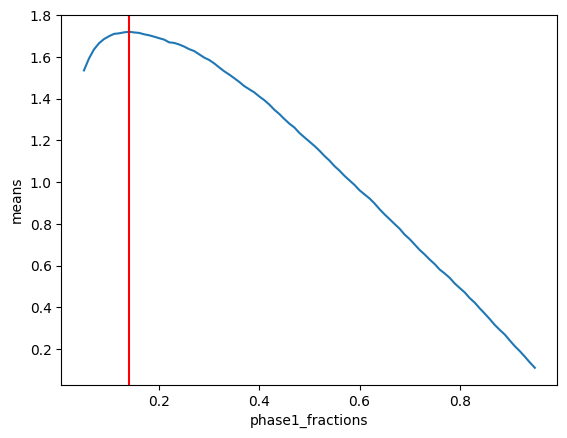

In [ ]:
max_means_frac = phase1_fractions[np.where(means == max(means))]
print("The phase1_fractions has max mean: ", max_means_frac[0])
plt.plot(phase1_fractions, means)
plt.axvline(max_means_frac, color = 'r')
plt.xlabel('phase1_fractions')
plt.ylabel('means')

# **Retirement Planning (Multi-Period)**

In [ ]:
###Howard's retirement fund
savings=1000000
inflation=0.03
withdraw=np.arange(50000,80001,500)

lifemu=20
lifesd=10
scalehat=(10**2)/20
ahat=lifemu/scalehat

S=5000

life=np.rint(stats.gamma.rvs(a=ahat,scale=scalehat,size=S))
life=np.array(life,dtype=int)

stats.describe(life)

DescribeResult(nobs=5000, minmax=(1, 73), mean=19.6734, variance=94.14396123224644, skewness=0.9880236845638098, kurtosis=1.424256348426793)

In [ ]:
life[0:4]

array([14, 22, 37, 25])

In [ ]:
growthmu=0.08
growthsd=0.02
simgrowth=[]

for s in range(S):
  growth_s=np.round(np.random.normal(growthmu, growthsd, life[s]),3)
  simgrowth.append(growth_s)

simgrowth[0:4]

[array([0.063, 0.138, 0.074, 0.105, 0.063, 0.098, 0.084, 0.046, 0.141,
        0.089, 0.097, 0.102, 0.082, 0.101]),
 array([0.104, 0.069, 0.116, 0.069, 0.105, 0.055, 0.068, 0.121, 0.101,
        0.071, 0.064, 0.09 , 0.087, 0.069, 0.093, 0.098, 0.124, 0.095,
        0.083, 0.091, 0.082, 0.075]),
 array([0.057, 0.061, 0.095, 0.057, 0.066, 0.088, 0.058, 0.093, 0.085,
        0.1  , 0.092, 0.08 , 0.042, 0.074, 0.087, 0.077, 0.085, 0.089,
        0.103, 0.092, 0.045, 0.075, 0.086, 0.107, 0.095, 0.101, 0.105,
        0.084, 0.065, 0.059, 0.086, 0.066, 0.085, 0.099, 0.038, 0.079,
        0.077]),
 array([0.055, 0.108, 0.089, 0.074, 0.068, 0.077, 0.087, 0.074, 0.102,
        0.042, 0.062, 0.073, 0.104, 0.088, 0.081, 0.091, 0.06 , 0.077,
        0.105, 0.11 , 0.055, 0.11 , 0.062, 0.067, 0.095])]

In [ ]:
simgrowth[0][3]

0.105

In [ ]:
S=5000
pbroke=np.empty(len(withdraw))

for i in range(0,len(withdraw)):
  broke_i=0
  for s in range(0,S):
    reslife=life[s]
    j=1
    spending=withdraw[i]
    savings_left=savings
    while j<=reslife and savings_left>0:
      savings_left=savings_left-spending
      savings_left=savings_left*(1+simgrowth[s][j-1])
      spending=spending*(1+inflation)
      j=j+1
    #
    if savings_left<=0:
      broke_i=broke_i+1
    #
  print('annual spending=',withdraw[i])
  pbroke[i]=broke_i/S


annual spending= 50000
annual spending= 50500
annual spending= 51000
annual spending= 51500
annual spending= 52000
annual spending= 52500
annual spending= 53000
annual spending= 53500
annual spending= 54000
annual spending= 54500
annual spending= 55000
annual spending= 55500
annual spending= 56000
annual spending= 56500
annual spending= 57000
annual spending= 57500
annual spending= 58000
annual spending= 58500
annual spending= 59000
annual spending= 59500
annual spending= 60000
annual spending= 60500
annual spending= 61000
annual spending= 61500
annual spending= 62000
annual spending= 62500
annual spending= 63000
annual spending= 63500
annual spending= 64000
annual spending= 64500
annual spending= 65000
annual spending= 65500
annual spending= 66000
annual spending= 66500
annual spending= 67000
annual spending= 67500
annual spending= 68000
annual spending= 68500
annual spending= 69000
annual spending= 69500
annual spending= 70000
annual spending= 70500
annual spending= 71000
annual spen

In [ ]:
withdraw[np.where(pbroke<0.05)]

array([50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000,
       54500])

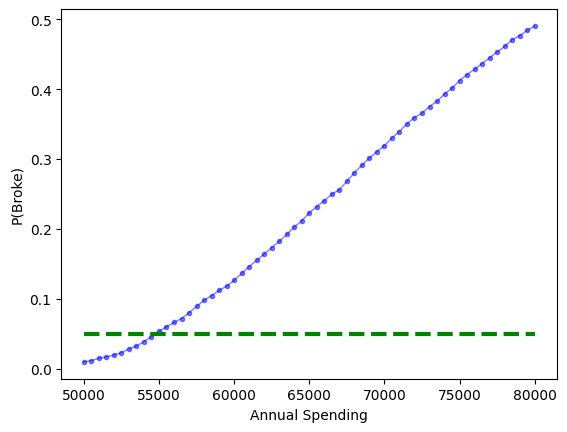

In [ ]:
plt.figure()
plt.plot(withdraw,pbroke,marker='.',color='b',lw=1,alpha=0.5)
plt.xlabel("Annual Spending")
plt.ylabel("P(Broke)")
plt.hlines(y=0.05, xmin=min(withdraw), xmax=max(withdraw),
             colors='green', linestyles='--',lw=3)

# **(s,S) Inventory Decisions (Multi-Period)**

In [ ]:
#Poisson demand parameter: 6 TVs per day
lambda_est=6

#Holding cost per item per day
h_val=0.6

unit_price=400
unit_cost=250

#Profit margin per TV sold
unit_profit=unit_price-unit_cost

#Cost per delivery from supplier to the dealer
shipping_cost=500

def InvModelsS(x):
  #
  #Set the seed for reproducibility
  np.random.seed(5566)
  s=x[0]
  S=x[1]
  #The number of simulation runs
  M=500
  #The number of days
  T=360
  #The experiment will be repeated for
  #m in 1:M repetitions & t in 1:T duration
  #Vector initialization
  #SL: service level
  SL=np.empty(M)
  daily_profit=np.empty(M)
  #
  for m in range(M):
    inv_onhand=np.empty(T+1)
    inv_onhand[0]=S
    sales=np.zeros(T)
    orderQ=np.zeros(T)
    #Keep track of inventory on-order but not arrived yet
    inv_onorder=np.array([])
    inv_onorder_stamp=np.array([])
    #The number of deliveries from the supplier
    delivery=0
    #The total amount of lost sales
    loss=0
    #The number of stockouts in a repetition
    stockout=0
    #Simulate Poisson demand for T periods
    d=np.random.poisson(lambda_est,T)
    arrival=0
    for t in range(T):
      if t==0:
        #Selling process
        sales[t]=min(inv_onhand[t],d[t])
        #Check stockout
        if (d[t]>sales[t]):
          stockout=stockout+1
          loss=loss+(d[t]-sales[t])
        #Compute inventory position
        inv_position=inv_onhand[0]
        #Ordering mechanism of (s, S)
        if inv_position<=s:
          #Compute order quantity
          Q=S-inv_position
          #Update inventory on-order
          inv_onorder=np.append(inv_onorder,Q)
          #Simulate stochastic lead time
          time_to_arrive=t+np.random.choice([4,5],size=1,p=[0.5,0.5])+1
          #Update time stamp for invenory on-order
          inv_onorder_stamp=np.append(inv_onorder_stamp,time_to_arrive)
          #Record order quantity
          orderQ[t]=Q
        #Update inventory on-hand in the end of each day
        inv_onhand[t+1]=inv_onhand[t]-sales[t]
       ###End t==0
      if t>0:
        #Check if any inventory on-order should arrive
        if np.any(inv_onorder_stamp==t):
          #Update the number of deliveries
          delivery=delivery+1
          #Compute the total of arrived inventories
          index=np.where(inv_onorder_stamp==t)
          arrival=np.sum(inv_onorder[index])
          #Update inventory on-hand before starting the day
          inv_onhand[t]=inv_onhand[t]+arrival
          #Removed those just arrived from inventory on-order
          inv_onorder=np.delete(inv_onorder,index)
          inv_onorder_stamp=np.delete(inv_onorder_stamp,index)
        #Record sales
        sales[t]=min(inv_onhand[t],d[t])
        #Check if any stockout takes place
        if d[t]>sales[t]:
          stockout=stockout+1
          loss=loss+d[t]-sales[t]
        #End if
        #Update inventory position
        inv_position=inv_onhand[t]+np.sum(inv_onorder)
        #Ordering mechanism of (s, S) inventory policy
        if (inv_position<=s):
          Q=S-inv_position
          inv_onorder=np.append(inv_onorder,Q)
          time_to_arrive=t+np.random.choice([4,5],size=1,p=[0.5,0.5])+1
          inv_onorder_stamp=np.append(inv_onorder_stamp,time_to_arrive)
          orderQ[t]=Q
        #Update inventory on-hand in the end of the day
        inv_onhand[t+1]=inv_onhand[t]-sales[t]
        ###End t>0
      #print("t=",t,"d=",d[t],"arrival=",arrival,"; inv_onhand=",inv_onhand[t],"; order(t)=",orderQ[t])
    ###End t loop
    #Calculate the service level (i.e., in-stock probability)
    SL[m]=(T-stockout)/t
    #Calculate the average daily profit
    daily_profit[m]=(unit_profit*np.sum(sales)-np.sum(h_val*inv_onhand)-shipping_cost*delivery-unit_profit*loss)/T
    #Print simulation progrss
    #if (np.remainder(m,100)==0):
    #  print("m=",m)
  return -1*np.mean(daily_profit)


In [ ]:
InvModelsS([10,150])

-578.8271377777778

In [ ]:
##Grid Search for optimal (s*, S*)
xval=np.array([(sval,Sval) for sval in range(10,61,5) for Sval in range(90,361,10)])
xval.shape
xval.shape[0]
resgrid=np.empty(xval.shape[0])
xval[0,]

for i in range(xval.shape[0]):
  resgrid[i]=InvModelsS(xval[i,])


KeyboardInterrupt: 

In [ ]:
id=np.argmin(resgrid)
print(resgrid[id])
print(xval[id])

-828.3000677777778
[ 50 150]


In [ ]:
##Use Pymoo for numerical optimization
## https://pymoo.org/index.html

##Define the optimization problem first
from pymoo.problems.functional import FunctionalProblem

problemInv=FunctionalProblem(n_var=2,objs=InvModelsS,
             xl=np.array([20,100]),xu=np.array([90,200]))
problemInv.evaluate(np.array([30,130]))

array([-735.55821333])

In [ ]:
##Hooke-Jeeves Search
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.optimize import minimize

resHK=minimize(problemInv,algorithm=PatternSearch(),verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 | -7.937889E+02 | -8.270817E+02
     2 |       24 | -8.272122E+02 | -8.273428E+02
     3 |       29 | -8.273428E+02 | -8.273428E+02
     4 |       32 | -8.279084E+02 | -8.284741E+02
     5 |       37 | -8.284741E+02 | -8.284741E+02
     6 |       40 | -8.284776E+02 | -8.284811E+02
     7 |       44 | -8.284023E+02 | -8.284811E+02
     8 |       48 | -8.284811E+02 | -8.284811E+02
     9 |       51 | -8.284813E+02 | -8.284815E+02
    10 |       55 | -8.284892E+02 | -8.284968E+02
    11 |       60 | -8.284400E+02 | -8.284968E+02
    12 |       64 | -8.284968E+02 | -8.284968E+02
    13 |       68 | -8.284987E+02 | -8.285005E+02
    14 |       73 | -8.285005E+02 | -8.285005E+02
    15 |       77 | -8.285021E+02 | -8.285037E+02
    16 |       82 | -8.285037E+02 | -8.285037E+02
    17 |       86 | -8.285037E+02 | -8.285037E+02
    18 |       89 | -8.285041E+02 | -8.285045E+02
    19 |       94 | -8.285045E+02 | -8.285045E+02


KeyboardInterrupt: ignored

In [ ]:
print("Best solution found: \nX = %s\nF = %s" % (resHK.X, resHK.F))

Best solution found: 
X = [ 49.41016442 143.        ]
F = [-828.50465778]


In [ ]:
##Nelder-Mead Search
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
resNM=minimize(problemInv,algorithm=NelderMead(),verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 | -7.851385E+02 | -8.280648E+02
     2 |       22 | -8.277352E+02 | -8.284646E+02
     3 |       26 | -8.278441E+02 | -8.280648E+02
     4 |       28 | -8.280908E+02 | -8.283070E+02
     5 |       30 | -8.281496E+02 | -8.283070E+02
     6 |       34 | -8.282211E+02 | -8.283070E+02
     7 |       36 | -8.282892E+02 | -8.283124E+02
     8 |       38 | -8.283381E+02 | -8.283950E+02
     9 |       42 | -8.283639E+02 | -8.283950E+02
    10 |       44 | -8.283774E+02 | -8.283950E+02
    11 |       46 | -8.283801E+02 | -8.283950E+02
    12 |       48 | -8.283944E+02 | -8.284136E+02
    13 |       50 | -8.283994E+02 | -8.284136E+02
    14 |       52 | -8.284018E+02 | -8.284136E+02
    15 |       54 | -8.284121E+02 | -8.284259E+02
    16 |       56 | -8.284350E+02 | -8.284655E+02
    17 |       58 | -8.284636E+02 | -8.284994E+02
    18 |       59 | -8.284847E+02 | -8.284994E+02
    19 |       61 | -8.284915E+02 | -8.284994E+02


In [ ]:
print("Best solution found: \nX = %s\nF = %s" % (resNM.X, resNM.F))